<h1 style="color:violet; text-align:center;">Assignment #4</h1>
<h3 style="color:violet; text-align:center;">Shahar Dekel 318864436</h3>
<h3 style="color:violet; text-align:center;">Amit Feiner 316552710</h3>

<h2>Loading the dataset</h2>

In [62]:
# install packages at first run
#!pip install pandas
#!pip install seaborn
#!pip install tabulate

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy
import warnings
warnings.filterwarnings('ignore')
from statsmodels.regression.linear_model import OLS, RegressionResults
from tabulate import tabulate
import statsmodels.api as sm

dataset='framingham_heart_disease.csv'
df=pd.read_csv(dataset, sep=',')
df.columns.values
# removing unwanted columns
df.drop(['prevalentStroke', 'prevalentHyp','totChol','sysBP','diaBP','TenYearCHD'], axis='columns', inplace=True)
for val in ['age', 'heartRate']:
    df[val].fillna(df[val].mean(), inplace=True)
for val in ['currentSmoker', 'male']:
    df[val].dropna()
df

,male,age,education,currentSmoker,cigsPerDay,BPMeds,diabetes,BMI,heartRate,glucose
0,1,39,4.0,0,0.0,0.0,0,26.97,80.0,77.0
1,0,46,2.0,0,0.0,0.0,0,28.73,95.0,76.0
2,1,48,1.0,1,20.0,0.0,0,25.34,75.0,70.0
3,0,61,3.0,1,30.0,0.0,0,28.58,65.0,103.0
4,0,46,3.0,1,23.0,0.0,0,23.10,85.0,85.0
...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,25.97,66.0,86.0
4234,1,51,3.0,1,43.0,0.0,0,19.71,65.0,68.0
4235,0,48,2.0,1,20.0,NaN,0,22.00,84.0,86.0
4236,0,44,1.0,1,15.0,0.0,0,19.16,86.0,NaN


<h2>Part 1- Linear Regression</h2>
<h3>In this part, we chose to focus on 'male' (binary), 'age' (continuos) and 'currentSmoker' (binary) as explanatory variables (X$_1$, X$_2$, X$_3$) and 'heartRate' (continuos) as explained variable (Y)
<br><br>
Our research question is- How does the sex, age and the fact that the person is a smoker or not affects the heart rate of the same person?

In [63]:
subset=df.sample(200)
subset
X = subset[['male','age','currentSmoker']]
X = sm.add_constant(X)
Y = subset['heartRate']
model = OLS(Y,X).fit()

<h3>1.</h3>

In [64]:
def calculate_ci(se, var):
    print('estimator for s.e.:',se)
    z=1.96 #the suitable precent for standard normal distribution
    ci = [se - z*np.sqrt(var), se + z*np.sqrt(var)]
    print(ci)
    return ci

In [65]:
print("A")

features = ['const','male','age','currentSmoker']
C = np.linalg.inv(X.T.dot(X))
Y_mean = Y.mean()
predictions = model.predict(X)
SS_Res = sum((predictions - Y)**2)
n,p = len(Y),len(features) 
df_Res=n-p
X = np.array(X)
MS_Res = SS_Res/df_Res


ci_normal = dict()

for i, val in enumerate(features):
    print("For the feature",val)
    se=model.params[val]
    var=MS_Res*C[i,i]
    ci_normal[val] = calculate_ci(se, var)

A
For the feature const
estimator for s.e.: 75.25725607995848
[64.08467065882324, 86.42984150109372]
For the feature male
estimator for s.e.: -1.833153545750843
[-5.30169648391872, 1.635389392417034]
For the feature age
estimator for s.e.: -0.01441900299081883
[-0.2309737288613423, 0.20213572287970463]
For the feature currentSmoker
estimator for s.e.: 2.5702784844823663
[-0.9402851651107276, 6.080842134075461]


In [66]:
print("B")
B = 400
sum_index = 0
cat_index = pd.DataFrame()

for i in range(B): 
    tmp = subset.sample(n=200, replace=True)
    X_new = tmp[['male','age','currentSmoker']]
    X_new = sm.add_constant(X_new)
    y_new = tmp['heartRate']
    model_new = OLS(y_new,X_new).fit()
    
    sum_index += model_new.params
    cat_index = pd.concat([cat_index,pd.DataFrame(model_new.params, columns=[f"{i+1}"])], axis = 1)
    
upper = cat_index.apply(lambda x: x**2).sum(axis=1)/B 
lower = cat_index.sum(axis=1).apply(lambda x: (x/B)**2)
bootstrap = upper - lower

ci_normal_bootstrap = dict()

for index, variable in enumerate(features):
    print("For the feature",variable)
    se=model.params[variable]
    var=bootstrap[variable]
    ci_normal_bootstrap[variable] = calculate_ci(se,var)

B
For the feature const
estimator for s.e.: 75.25725607995848
[64.79033784973446, 85.7241743101825]
For the feature male
estimator for s.e.: -1.833153545750843
[-5.426098138657259, 1.7597910471555727]
For the feature age
estimator for s.e.: -0.01441900299081883
[-0.2168400152307169, 0.18800200924907923]
For the feature currentSmoker
estimator for s.e.: 2.5702784844823663
[-0.7599529404215715, 5.9005099093863045]


In [67]:
print("C")
def ci_pivot(estimator, bootstrap):
    alpha = 0.05
    bootstrap.sort()
    lower = bootstrap[int(B*(1-alpha/2))]
    upper = bootstrap[int(B*(alpha/2))]
    ci = [2* estimator - lower, 2* estimator - upper]
    print(ci)
    return ci

ci_pivotal = dict()

for i, val in enumerate(features):
    print("For the feature",val)
    estimator=model.params[val]
    boot=np.array(cat_index.T[val])
    ci_pivotal[val] = ci_pivot(estimator,boot)

C
For the feature const
[65.60576801385668, 85.51137823044756]
For the feature male
[-5.6426711243361805, 1.5325400019838291]
For the feature age
[-0.21406567687045353, 0.17230158535856382]
For the feature currentSmoker
[-1.2469360345032143, 5.4473430467853134]


In [68]:
print("D")
ci_precentile = dict()
alpha = 0.05

for i, val in enumerate(features):
    tmp = np.array(cat_index.T[val])
    tmp.sort()
    print("For the feature",val)
    ci_precentile[val] = [tmp[int(B*(alpha/2))], tmp[int(B*(1-alpha/2))]]
    print(ci_precentile[val])

D
For the feature const
[65.0031339294694, 84.90874414606029]
For the feature male
[-5.198847093485515, 1.9763640328344942]
For the feature age
[-0.20113959134020148, 0.18522767088881587]
For the feature currentSmoker
[-0.30678607782058087, 6.387493003467947]


<h3>2.</h3>

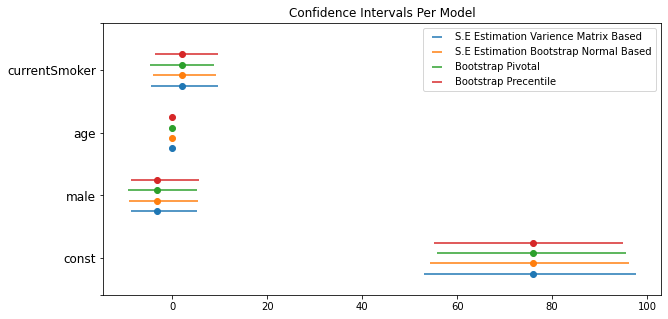

All confidence intervals contains the betas from the full model


In [69]:
# coefficients based on all the data
X = df[['male','age','currentSmoker']]
X = sm.add_constant(X)
Y = df['heartRate']
full = OLS(Y,X).fit()

n = 0
estimates=dict()
for i in features:
    estimates[i] = n
    n += 1
errors_count = dict()
y = [1, 4, 7, 10]

plt.figure(figsize=(10,5))
methods = ['S.E Estimation Varience Matrix Based', 'S.E Estimation Bootstrap Normal Based', 'Bootstrap Pivotal','Bootstrap Precentile']
intervals_types = [ci_normal, ci_normal_bootstrap, ci_pivotal, ci_precentile]
for method, intervals in zip(methods,intervals_types):
    error, x, estimator = [0]*4, [0]*4, [0]*4
    for key, val in intervals.items():
        x[estimates[key]] = np.mean(val)
        error[estimates[key]] = val[1]-val[0]
        errors_count[key,method] = round(val[1]-val[0],4)
        estimator[estimates[key]] = full.params[key]
    
    plt.errorbar(x, y, xerr=error, label=method, linestyle = 'None')
    plt.scatter(estimator,y)
    
    y = [i+0.5 for i in y]

    
plt.title("Confidence Intervals Per Model")    
plt.legend(loc='upper right')
plt.yticks((0, 1.75, 4.75, 7.75, 10.75, 13), ('', 'const', 'male','age','currentSmoker',''),fontsize=12)
plt.show()


real_beta=full.params
cnt=0
for i in (features):
    for method, intervals in zip(methods,intervals_types):
        if not (intervals[i][0] <= real_beta[i] <= intervals[i][1]):
            print(f"The CI calculated by {method} does not contains {i} coff.\n the interval is {intervals[i]} and the real beta is {real_beta[i]}")
        else:
            cnt+=1
if cnt == len(intervals)*len(methods):
    print("All confidence intervals contains the betas from the full model")

<h3>3.</h3>

In [70]:
subset100 = df[~(df.index.isin(subset.index.values))].sample(n=100)
subset100 = subset100[['male','age','currentSmoker','heartRate']]
subset100

,male,age,currentSmoker,heartRate
1150,0,46,1,70.0
3190,0,46,1,80.0
2245,0,53,0,100.0
3168,0,53,0,67.0
300,1,38,0,72.0
...,...,...,...,...
291,1,48,0,69.0
3404,0,62,0,76.0
2592,0,37,0,82.0
328,0,59,0,90.0


In [71]:
print("A")
X_new = subset100[['male','age','currentSmoker']]
X_new = sm.add_constant(X_new)
Y_new = subset100['heartRate']
Y_pred = model.predict(X_new)
print("Predictions for the new subset containing 100 new points\n",Y_pred)

A
Predictions for the new subset containing 100 new points
 1150    77.164260
3190    77.164260
2245    74.493049
3168    74.493049
300     72.876180
          ...    
291     72.731990
3404    74.363278
2592    74.723753
328     74.406535
190     75.446459
Length: 100, dtype: float64


In [72]:
print("B")
cat_pred = pd.DataFrame()

for i in range(B):
    tmp = subset.sample(n=200, replace=True) 
    X100 = tmp[['male','age','currentSmoker']]
    X100 = sm.add_constant(X100)
    Y100 = tmp['heartRate']
    model_temp = OLS(Y100,X100).fit()
    Y100_pred_temp = model_temp.predict(X_new)
    cat_pred = pd.concat([cat_pred,pd.DataFrame(Y100_pred_temp, columns=[f"{i+1}"])], axis = 1)

left = cat_pred.apply(lambda x: x**2).sum(axis=1)/B 
right = cat_pred.sum(axis=1).apply(lambda x: (x/B)**2)
bootstrap_se = np.sqrt(left - right)

subset100['Y100_pred'] = Y_pred
subset100['s.e'] = bootstrap_se 
subset100['lower'] = subset100['Y100_pred'] - 1.96*subset100['s.e']
subset100['upper'] = subset100['Y100_pred'] + 1.96*subset100['s.e']

print(subset100[['lower','upper']])

B
          lower      upper
1150  74.098081  80.230440
3190  74.098081  80.230440
2245  72.062916  76.923182
3168  72.062916  76.923182
300   68.602175  77.150186
...         ...        ...
291   69.266420  76.197561
3404  71.009998  77.716558
2592  71.348532  78.098974
328   71.441602  77.371468
190   71.671164  79.221754

[100 rows x 2 columns]


In [73]:
print("C")
cnt=0
for i in Y_new.index:
    if subset100['lower'][i]<=Y_new[i]<=subset100['upper'][i]:
        cnt+=1
print(f"The precent of the real Ys that are in the CI is {cnt}%")
    

C
The precent of the real Ys that are in the CI is 20%


<h3>Part 2- Tests</h3>

<h3>Our Test Question</h3>
<br>
(the question from pare 2 was
    Are the values of 'heartRate' different between different levels of 'currentSmoker'?)


## Q1.

#### Test Question:

#### Is the distribution of the HEART RATE of SMOKERS higher stochasticly than the distribution of the HEART RATE of NON SMOKERS?

## Q2.


In [74]:

samples2 = subset[['heartRate','currentSmoker']].sample(200, random_state=0)

df2 = subset[['heartRate','currentSmoker']]
df2.dropna(inplace=True)
df2.loc[df2['currentSmoker'] == 0 , 'currentSmoker'] = 1
df2.loc[df2['currentSmoker'] == 1 , 'currentSmoker'] = 0

# drop records with missing values
samples2.dropna(inplace=True)
n = samples2.shape[0]
print("Number of records:", n)
samples2.loc[samples2['currentSmoker'] == 1 , 'currentSmoker'] = 1
samples2.loc[samples2['currentSmoker'] == 0 , 'currentSmoker'] = 0
n_nonSmokers = samples2[samples2['currentSmoker'] == 0].shape[0]
n_smokers = samples2[samples2['currentSmoker'] == 1].shape[0]
print(f"{n_smokers} smokers and {n_nonSmokers} non smokers")
samples2

Number of records: 200
106 smokers and 94 non smokers


,heartRate,currentSmoker
3345,60.0,1
385,62.0,0
1566,75.0,1
3529,65.0,0
2496,84.0,0
...,...,...
3513,71.0,0
2454,67.0,0
2448,68.0,1
4144,90.0,0


## Q3.

Define $\mu_1 = \mu_m$ the average heart rate of smokers and $\mu_2 = \mu_f$ the average heart rate of non smokers based on the full data.
Where $\delta=\mu_1-\mu_2$

A) Estimate $\mu_1$ by $\hat{\mu_1}$ - the average heart rate of smokers from the 200 sampled people. Similarly for non smokers.
And $\hat{\delta}=\hat{\mu_1}-\hat{\mu_2}$

In [75]:
mu_s_hat = samples2[samples2['currentSmoker'] == 1].mean()[0]
mu_n_hat = samples2[samples2['currentSmoker'] == 0].mean()[0]
delta_hat = mu_n_hat - mu_s_hat
print(f"mu_s estimator: {round(mu_s_hat,4)}, mu_n estimator: {round(mu_n_hat,4)}, delta estimator: {round(delta_hat,4)}")

mu_s estimator: 76.1038, mu_n estimator: 73.9468, delta estimator: -2.157


Text(0.5, 1.0, 'non smokers heart rate histogram')

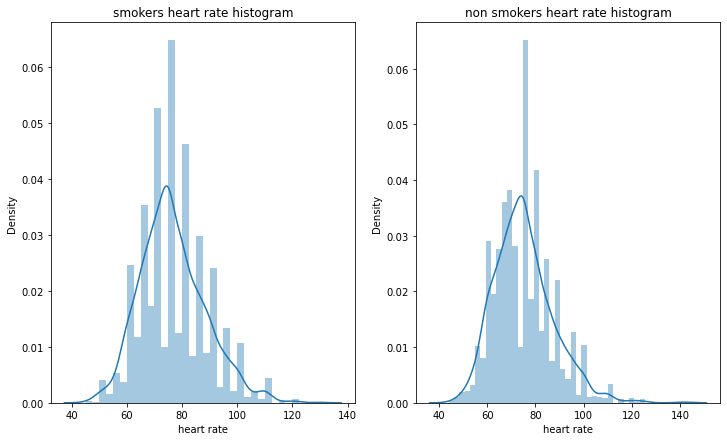

In [76]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2,figsize = (12,7))
sns.distplot(df.loc[df['currentSmoker'] == 1]['heartRate'], ax=axs[0], axlabel='heart rate')
sns.distplot(df.loc[df['currentSmoker'] == 0]['heartRate'], ax=axs[1], axlabel='heart rate')
axs[0].set_title('smokers heart rate histogram')
axs[1].set_title('non smokers heart rate histogram')


Both distributions look like roughly normal ditribution, but with slightly longer right tail and tranceted left tail.

so we assume normal dustribution model.


##B.

In [77]:
from math import sqrt
var_smokers = samples2[samples2['currentSmoker'] == 1].var()[0]/n_smokers
var_nonSmokers = samples2[samples2['currentSmoker'] == 0].var()[0]/n_nonSmokers

se_delta = sqrt(var_smokers + var_nonSmokers)
print(f"CI for delta is [{delta_hat-2*se_delta}, {delta_hat+2*se_delta}]")

CI for delta is [-5.523276376643453, 1.2093462281087017]


## C.

In [78]:
mu_s = df2[df2['currentSmoker'] == 1].mean()[0]
mu_n = df2[df2['currentSmoker'] == 0].mean()[0]
delta = mu_n - mu_s
print(f"the real parameter delta is {round(delta,4)}")

the real parameter delta is nan


As we can see, the CI from the previous section contains the $\delta$ calculated on the whole data.

##D.

In [79]:
from scipy import stats

var_smokers2 = samples2[samples2['currentSmoker'] == 1].var(ddof=0)[0]
var_nonSmokers2 = samples2[samples2['currentSmoker'] == 0].var(ddof=0)[0]

w_statistic = (delta_hat)/sqrt(var_nonSmokers2 + var_smokers2)
print(f"Wald-test results : statistic: {w_statistic}")

Wald-test results : statistic: -0.12824563530427227


Based on the Wald test we got $T < Z_{1-\alpha}=0.027$ therefore we do not reject the null hypothesis, meaning that we do not have evidence to say that the heart rate of smokers is higher than that of non smokers.

In [80]:
T_obs = delta_hat
n_nonSmokers = samples2[samples2['currentSmoker'] == 0].shape[0]
np.random.seed(0)
indicator_sums = 0
for b in range(B):
    curr_samples = samples2.sample(n=n_nonSmokers, replace=True ,random_state=b)
    if curr_samples.mean()[0] >= T_obs:
        indicator_sums += 1
        
pvalue = indicator_sums / B
print("Pvalue for Premuttions Test:", pvalue)

Pvalue for Premuttions Test: 1.0


Based on the Premutations Test we got $pvalue>0.05$ therefore we do not reject the null hypothesis, meaning we do not have evidence that the distribution of the heart rate of smokers higher stochasticly than the heart rate of non smoker.

##Q4.
Define $m_1 = m_nonSmokers$ the median heart rate of non smokers and $m_2 = m_smokers$ the median heart rate of smokers based on the full data.
Where $\delta=m_1-m_2$

###A

In [81]:
m_n_hat = samples2[samples2['currentSmoker'] == 1].median()[0]
m_s_hat = samples2[samples2['currentSmoker'] == 0].median()[0]
delta_hat_2 = m_s_hat - m_n_hat
print(f"m_n estimator: {round(m_n_hat,4)}, m_s estimator: {round(m_s_hat,4)}, delta estimator: {round(delta_hat_2,4)}")

m_n estimator: 75.0, m_s estimator: 73.0, delta estimator: -2.0


As we shown in Q3.A we assume Normal distribution model. In normal dustibution, the median is equal to the mean. therfore as we know the mle for the median (mean) is the average based on the n samples therfore the median is not mle.

###B

In [82]:
betas_bootstrap_3 = np.zeros(B)
for b in range(B):
    curr_samples = samples2.sample(n=n, replace=True ,random_state=b)
    betas_bootstrap_3[b] = curr_samples[curr_samples['currentSmoker'] == 1].median()[0] - curr_samples[curr_samples['currentSmoker'] == 0].median()[0]
ci_6 = np.zeros((1,2))
betas_bootstrap_sort_3 = np.sort(betas_bootstrap_3,axis=0)
ci_6[0,0] = betas_bootstrap_sort_3[9]
ci_6[0,1] = betas_bootstrap_sort_3[389]
conf_int = pd.DataFrame(ci_6)
conf_int.columns = ['Lower','Upper']
print("CI for each of the median:")
conf_int

CI for each of the median:


,Lower,Upper
0,-3.0,5.0


###C

In [83]:
m_s = df2[df2['currentSmoker'] == 1].median()[0]
m_n = df2[df2['currentSmoker'] == 0].median()[0]
delta2 = m_s - m_n
print(f"the real parameter delta is {round(delta2,4)}")

the real parameter delta is nan


As we can see, the CI from the previous section contains the $\delta$ 

---

calculated on the whole data.

###D


#### Permutation Test with resampling:


$H_0 : F_X = F_Y$

$H_1 : X \prec Y$


$T^{obs} = M(Y_{n_m})-M(X_{n_f})$

Procedure:

Sample B sample size n_m randomly and for each calculate $T^b$.

Reject $H_0$ iff

$\frac{\sum_{b=1}^B I\{T^b \geq T^{obs}\}}{B} \leq \alpha$

in oue case Y - heart rate of smokers, X - heart rate of non smokers.

In [84]:
T_obs = delta_hat_2
n_n = samples2[samples2['currentSmoker'] == 0].shape[0]
np.random.seed(0)
indicator_sums = 0
for b in range(B):
    curr_samples = samples2.sample(n=n_n, replace=True ,random_state=b)
    if curr_samples.median()[0] >= T_obs:
        indicator_sums += 1
        
pvalue = indicator_sums / B
print("Pvalue for Premuttions Test:", pvalue)

Pvalue for Premuttions Test: 1.0


Based on the Premuttions Test we got $pvalue>0.05$ therefore we do not reject the null hypothesis, meaning we do not have evidence that the distribution of the heart rate of smokers higher stochasticly than the heart rate of non smokers.

###E
<br>
As we learned in class the T test is for difference in means and not for 
*   List item
medians. So based on what we learned we cannot do T test for this case.
As we learned in class the Wald test is based on statistic that is asymptotically normal distributed.
it can shown that the median in asymptotically normal distributed so we can use Wald test for this case.

##Q5

### Permutation Test with resampling: 

$H_0 : F_X = F_Y$

$H_1 : X \prec Y$ 

$W_S^{obs} = \sum_{i=i}^n S_i$

Where $S_i = |\{j:X_j < Y_i\}| + |\{j:Y_j \leq Y_i\}| \ \ , \ \forall i \in [n]$

Procedure:

Sample B times n_m rankings randomly and for each calculate $W_S^b$.

Reject $H_0$ iff

$\frac{\sum_{b=1}^B I\{W_S^b \geq W_S^{obs}\}}{B} \leq \alpha$

in oue case Y -heart rate of non smokers, X - heart rate of smokers.

In [85]:
samples2 = samples2.sort_values(by=['currentSmoker'])

n_nonSmokers = samples2[samples2['currentSmoker'] == 1].shape[0]
n_smokers = samples2[samples2['currentSmoker'] == 0].shape[0]

ranks = stats.rankdata(samples2['heartRate'], method='average')

w_s_obs = ranks[:n_smokers].sum()

np.random.seed(0)
indicator_sums = 0
for b in range(B):
    curr_ranks = np.random.choice(ranks,size=n_nonSmokers)
    if curr_ranks.sum() >= w_s_obs:
        indicator_sums += 1
        
pvalue = indicator_sums / B
print("Pvalue for Wilcoxson Rank Test:", pvalue)

Pvalue for Wilcoxson Rank Test: 0.9975


#### Permutation Test with Normal approximation:

To use Normal approximation we need that we will not have ties in the ranks beacuse as we saw in class, the Permutation Test with Normal approximation is True only is under $H_0$ the ranks are uniformaly distributed.

number of ties 45


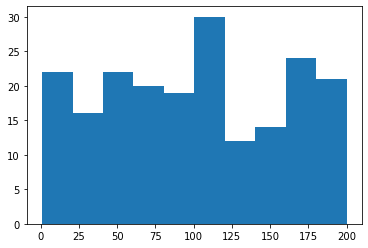

In [86]:
print("number of ties", np.unique(ranks).shape[0])
plt.hist(ranks, bins=10)
plt.show()

The Graph represent the distribution of the ranks under $H_0$.

By the graph and the results we can see that we have a lot of ties ranks (43) and we don't have uniform distribution therfore we can not use the normal aprroximation for $W_s$ as needed.
Therfore, we can not use the Permutation Test with Normal approximation.

##Q6

we explain and disccus 3-5 questions results above